In [ ]:
import xgboost as xgb
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns



In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split

In [ ]:
df_kiwi = pd.read_csv("flight_data_kiwi_allsnaps_clean.csv")
df_momondo = pd.read_csv("flight_data_momondo_All_combined_Cloud.csv")

In [224]:
# הצגת מספר שורות ראשונות מכל קובץ
print(df_kiwi.head())
print(df_momondo.head())

    Snap Date    Dep Date Return Date  Outbound Dep Time Dep Duration  \
0  2025-03-02  2025-03-03  2025-03-04  Outbound    11:50       1h 10m   
1  2025-03-02  2025-03-03  2025-03-04  Outbound    13:20       1h 20m   
2  2025-03-02  2025-03-03  2025-03-04  Outbound    18:35       1h 20m   
3  2025-03-02  2025-03-03  2025-03-04  Outbound    07:10       1h 20m   
4  2025-03-02  2025-03-03  2025-03-04  Outbound    19:25       1h 15m   

  Dep Arrival From  Stops Landing  Inbound Back Time Back Duration  \
0       14:00  SEN      0     CDG  Inbound     14:10        1h 15m   
1       15:40  LTN      0     CDG  Inbound     14:10        1h 15m   
2       20:55  LTN      0     CDG  Inbound     14:10        1h 15m   
3       09:30  LTN      0     CDG  Inbound     14:10        1h 15m   
4       21:40  LGW      0     ORY  Inbound     14:10        1h 15m   

  Back Arrival From.1  Stops.1 Landing.1 Dep Company Back Company  Price  
0        14:25    ORY        0       LHR     easyJet      easyJet

In [225]:
print(df_kiwi.info())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271981 entries, 0 to 271980
Data columns (total 20 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Snap Date      271981 non-null  object
 1   Dep Date       271981 non-null  object
 2   Return Date    271981 non-null  object
 3   Outbound       271981 non-null  object
 4   Dep Time       271981 non-null  object
 5   Dep Duration   271981 non-null  object
 6   Dep Arrival    271981 non-null  object
 7   From           271981 non-null  object
 8   Stops          271981 non-null  int64 
 9   Landing        271981 non-null  object
 10  Inbound        271981 non-null  object
 11  Back Time      271981 non-null  object
 12  Back Duration  271981 non-null  object
 13  Back Arrival   271981 non-null  object
 14  From.1         271981 non-null  object
 15  Stops.1        271981 non-null  int64 
 16  Landing.1      271981 non-null  object
 17  Dep Company    271981 non-null  object
 18  Back

In [226]:
print(df_momondo.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 281927 entries, 0 to 281926
Data columns (total 17 columns):
 #   Column                         Non-Null Count   Dtype 
---  ------                         --------------   ----- 
 0   Snap Date                      281927 non-null  object
 1   Dep Date                       281927 non-null  object
 2   Return Date                    281927 non-null  object
 3   Dep time                       281927 non-null  object
 4   Dep Company                    281927 non-null  object
 5   Stops                          281927 non-null  object
 6   Dep Duration                   281927 non-null  object
 7   From Airport                   281927 non-null  object
 8   Landing Airport                281927 non-null  object
 9   Back Time                      281927 non-null  object
 10  Back Company                   281927 non-null  object
 11  Stops.1                        281927 non-null  object
 12  Back Duration                  281927 non-nu

In [ ]:
def clean_price(price):
    """ מנקה את המחיר וממיר אותו למספר """
    if isinstance(price, str):
        price = re.sub(r"[^\d.]", "", price)  # הסרת תווים לא מספריים
        return float(price) if price else None
    return None

# המרת עמודת המחיר למספרים (float)
df_momondo["Price"] = df_momondo["Price"].apply(clean_price)
df_momondo["Price"] = (df_momondo["Price"] * 3.67).round(3)


df_kiwi["Price"] = df_kiwi["Price"].apply(clean_price)

# ✅ 2. המרת תאריכים לפורמט datetime
date_columns = ["Snap Date", "Dep Date", "Return Date"]

for col in date_columns:
    df_kiwi[col] = pd.to_datetime(df_kiwi[col], errors='coerce')
    df_momondo[col] = pd.to_datetime(df_momondo[col], errors='coerce')


def duration_to_minutes(duration):
    """ ממיר משך זמן בפורמט '1h 30m' למספר בדקות """
    if isinstance(duration, str):
        hours = 0
        minutes = 0
        parts = duration.split(" ")
        for part in parts:
            if 'h' in part:
                hours = int(part.replace("h", ""))
            if 'm' in part:
                minutes = int(part.replace("m", ""))
        return hours * 60 + minutes
    return None

# המרת משך זמן למספר בדקות ב-Kiwi
df_kiwi["Dep Duration"] = df_kiwi["Dep Duration"].apply(duration_to_minutes)
df_kiwi["Back Duration"] = df_kiwi["Back Duration"].apply(duration_to_minutes)

# המרת משך זמן למספר בדקות ב-Momondo
df_momondo["Dep Duration"] = df_momondo["Dep Duration"].apply(duration_to_minutes)
df_momondo["Back Duration"] = df_momondo["Back Duration"].apply(duration_to_minutes)

def convert_stops(stops):
    """ ממיר עצירות לטיפוס מספרי (0 עבור nonstop) """
    if isinstance(stops, str):
        stops = stops.lower().strip()  # מנקה רווחים וממיר לאותיות קטנות
        if "nonstop" in stops:
            return 0
        elif "stop" in stops:
            return int(stops.split(" ")[0])  # לוקח את המספר מתוך "1 stop"
    elif isinstance(stops, (int, float)):  # אם זה כבר מספר, מחזירים אותו
        return stops
    return None  # אם לא מזוהה, מחזירים None

df_kiwi["Stops"] = df_kiwi["Stops"].apply(convert_stops)
df_kiwi["Stops.1"] = df_kiwi["Stops.1"].apply(convert_stops)

df_momondo["Stops"] = df_momondo["Stops"].apply(convert_stops)
df_momondo["Stops.1"] = df_momondo["Stops.1"].apply(convert_stops)

df_momondo.to_csv("cleaned_flight_data_momondo.csv", index=False)
df_kiwi.to_csv("cleaned_flight_data_kiwi_allsnaps.csv", index=False)


print("הקבצים נשמרו בהצלחה!")

הקבצים נשמרו בהצלחה!


In [228]:
# ✅ בדיקת ערכים חסרים בקובץ של Kiwi
print("\n📌 Missing values in Kiwi dataset:")
print(df_kiwi.isnull().sum())

# ✅ בדיקת ערכים חסרים בקובץ של Momondo
print("\n📌 Missing values in Momondo dataset:")
print(df_momondo.isnull().sum())



📌 Missing values in Kiwi dataset:
Snap Date        0
Dep Date         0
Return Date      0
Outbound         0
Dep Time         0
Dep Duration     0
Dep Arrival      0
From             0
Stops            0
Landing          0
Inbound          0
Back Time        0
Back Duration    0
Back Arrival     0
From.1           0
Stops.1          0
Landing.1        0
Dep Company      0
Back Company     0
Price            0
dtype: int64

📌 Missing values in Momondo dataset:
Snap Date                           0
Dep Date                            0
Return Date                         0
Dep time                            0
Dep Company                         0
Stops                              41
Dep Duration                        0
From Airport                        0
Landing Airport                     0
Back Time                           0
Back Company                        0
Stops.1                          1124
Back Duration                       0
(Back Ticket) From Airport          0
(B

In [229]:
df_kiwi.dropna(inplace=True)
df_momondo.dropna(inplace=True)

In [ ]:


# ✅ 3. יצירת DataFrame משולב
df_combined = df_kiwi.copy()
df_combined["Price_Momondo"] = df_momondo["Price"]  # הוספת מחיר ממומונדו
df_combined["Price_Diff"] = df_combined["Price_Momondo"] - df_combined["Price"]  # חישוב הפרש מחירים

# ✅ 4. המרת תאריכים ליום בשבוע
df_combined["Dep_Weekday"] = df_combined["Dep Date"].dt.weekday  # 0=שני, 6=ראשון
df_combined["Return_Weekday"] = df_combined["Return Date"].dt.weekday

# ✅ 5. חישוב קרבה לסוף החודש (כמה ימים נשארו)
df_combined["Days_To_End_Month"] = df_combined["Dep Date"].dt.days_in_month - df_combined["Dep Date"].dt.day

# ✅ 6. טיפול בערכים חסרים בעמודת Price_Diff (נמלא עם חציון)
df_combined["Price_Diff"].fillna(df_combined["Price_Diff"].median(), inplace=True)

# ✅ 7. בחירת מאפיינים לחיזוי
features = ["Stops", "Dep Duration", "Back Duration", "Dep_Weekday", "Return_Weekday", "Days_To_End_Month"]
target = "Price_Diff"

X = df_combined[features]  # מאפיינים (features)
y = df_combined[target]  # המשתנה שאנחנו רוצים לחזות

# ✅ 8. פיצול הנתונים ל-Train/Test (70% אימון, 30% בדיקה)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# ✅ 9. בדיקה שהכל תקין
print(f"Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")
print(df_combined.head())

Train size: 190386, Test size: 81595
   Snap Date   Dep Date Return Date  Outbound Dep Time  Dep Duration  \
0 2025-03-02 2025-03-03  2025-03-04  Outbound    11:50            70   
1 2025-03-02 2025-03-03  2025-03-04  Outbound    13:20            80   
2 2025-03-02 2025-03-03  2025-03-04  Outbound    18:35            80   
3 2025-03-02 2025-03-03  2025-03-04  Outbound    07:10            80   
4 2025-03-02 2025-03-03  2025-03-04  Outbound    19:25            75   

  Dep Arrival From  Stops Landing  ... Stops.1 Landing.1  Dep Company  \
0       14:00  SEN      0     CDG  ...       0       LHR      easyJet   
1       15:40  LTN      0     CDG  ...       0       LHR      easyJet   
2       20:55  LTN      0     CDG  ...       0       LHR      easyJet   
3       09:30  LTN      0     CDG  ...       0       LHR      easyJet   
4       21:40  LGW      0     ORY  ...       0       LHR      easyJet   

  Back Company  Price  Price_Momondo Price_Diff Dep_Weekday Return_Weekday  \
0      easyJe

C:\Users\orian\AppData\Local\Temp\ipykernel_21004\2243840019.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_combined["Price_Diff"].fillna(df_combined["Price_Diff"].median(), inplace=True)


Training Linear Regression...


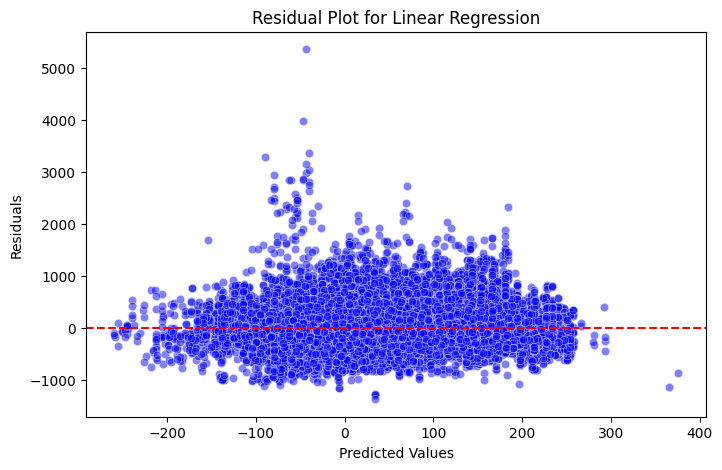

Training Decision Tree (Depth=5)...


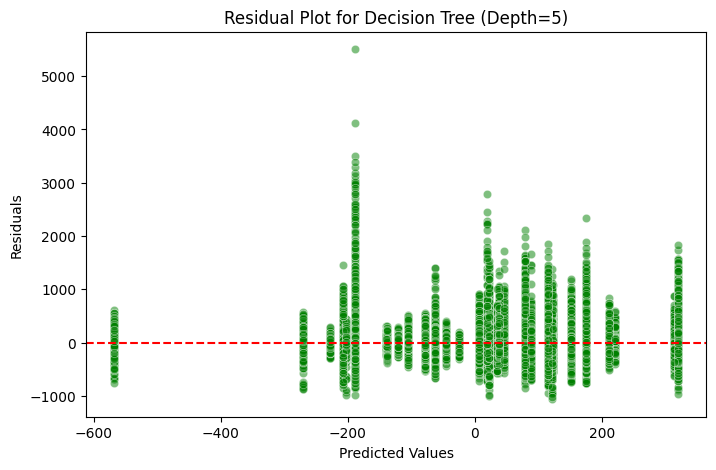

Training Decision Tree (Depth=10)...


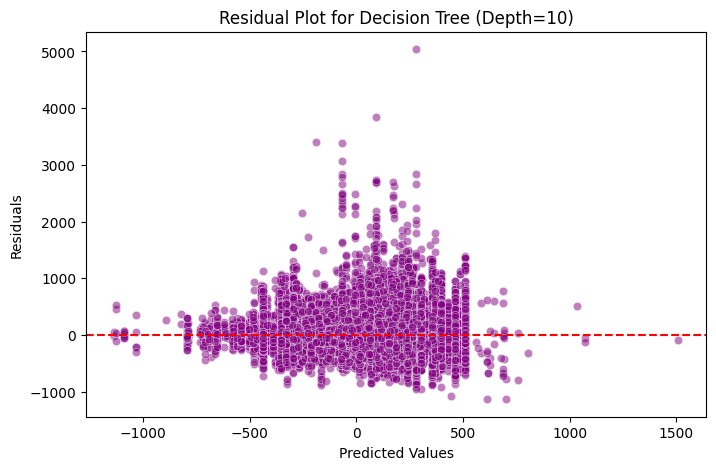

Training ElasticNet Regressor...


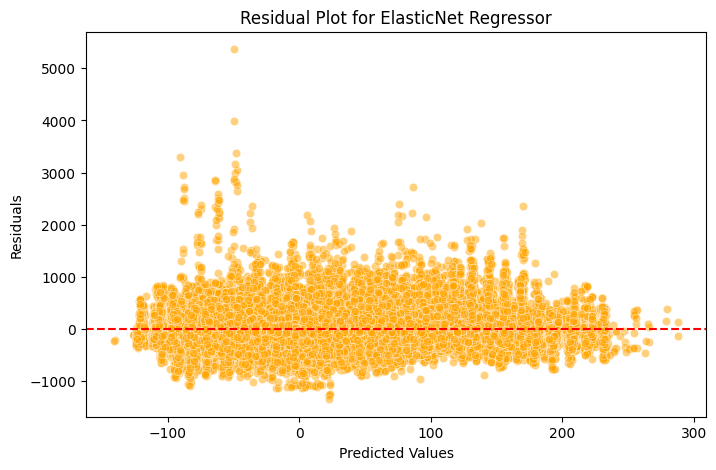

Training XGBoost Regressor...


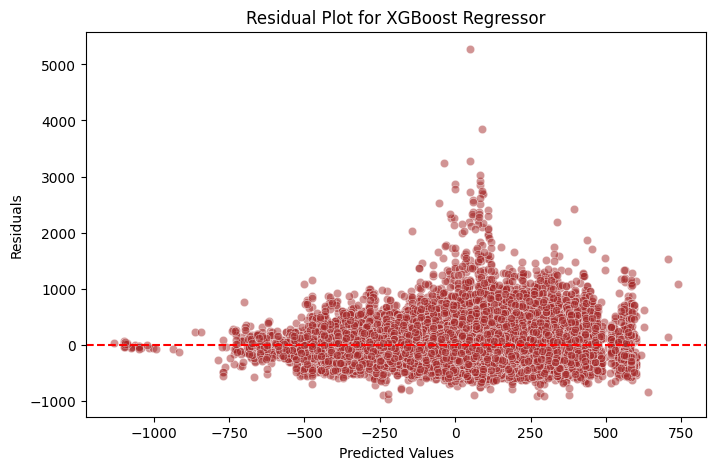

Training HistGradientBoosting Regressor...


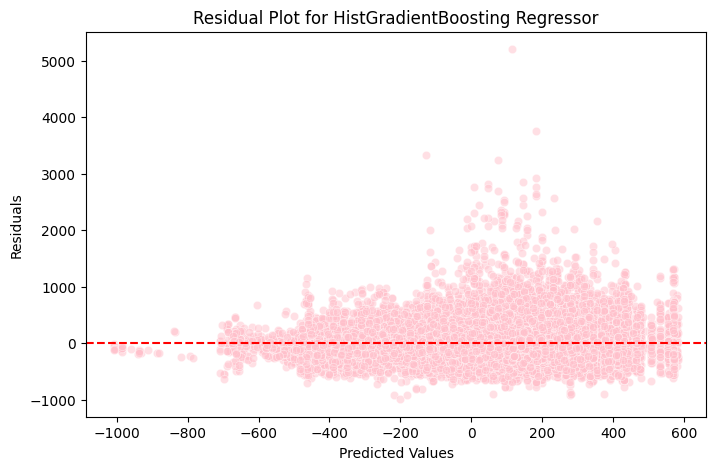


📌 תוצאות כל המודלים:

                                Train RMSE   Test RMSE      Test MSE  \
Linear Regression               294.299463  293.839141  86341.440532   
Decision Tree (Depth=5)         268.981997  269.677377  72725.887646   
Decision Tree (Depth=10)        238.590913  241.901840  58516.500422   
ElasticNet Regressor            295.002680  294.638315  86811.736752   
XGBoost Regressor               236.329118  238.494793  56879.766247   
HistGradientBoosting Regressor  237.156008  238.874506  57061.029760   

                                  Test MAE   Test R2  
Linear Regression               216.588313  0.066617  
Decision Tree (Depth=5)         196.329578  0.213807  
Decision Tree (Depth=10)        173.779929  0.367415  
ElasticNet Regressor            217.305278  0.061533  
XGBoost Regressor               171.920855  0.385109  
HistGradientBoosting Regressor  172.704818  0.383149  


In [231]:
# ✅ יצירת רשימת צבעים עבור ה-Residual Plot
color_palette = ["blue", "green", "purple", "orange", "brown", "pink", "cyan", "magenta"]
color_index = 0  # משתנה שיעזור לנו לעבור בין הצבעים

# ✅ יצירת מילון עם המודלים החדשים
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree (Depth=5)": DecisionTreeRegressor(max_depth=5),
    "Decision Tree (Depth=10)": DecisionTreeRegressor(max_depth=10),
    "ElasticNet Regressor": ElasticNet(alpha=0.1, l1_ratio=0.5),
    "XGBoost Regressor": xgb.XGBRegressor(n_estimators=100, learning_rate=0.1),
    "HistGradientBoosting Regressor": HistGradientBoostingRegressor(max_iter=100, learning_rate=0.1)
}

# ✅ אחסון תוצאות הביצועים
results = {}

# ✅ לולאה אחת שמבצעת גם אימון וגם מדפיסה את ה-Residual Plot
for name, model in models.items():
    print(f"Training {name}...")

    # אימון המודל
    model.fit(X_train, y_train)

    # חיזוי על סט האימון והבדיקה
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # חישוב השאריות (Residuals)
    residuals_test = y_test - y_pred_test

    # חישוב מדדי שגיאה
    train_mse = mean_squared_error(y_train, y_pred_train)
    test_mse = mean_squared_error(y_test, y_pred_test)
    train_rmse = train_mse ** 0.5
    test_rmse = test_mse ** 0.5
    test_mae = mean_absolute_error(y_test, y_pred_test)
    test_r2 = r2_score(y_test, y_pred_test)

    # ✅ שמירת התוצאות
    results[name] = {
        "Train RMSE": train_rmse,
        "Test RMSE": test_rmse,
        "Test MSE": test_mse,
        "Test MAE": test_mae,
        "Test R2": test_r2
    }

    # ✅ שימוש בצבע אחר לכל מודל
    color = color_palette[color_index % len(color_palette)]  
    color_index += 1  

    # ✅ יצירת ה-Residual Plot לכל מודל מיד אחרי הריצה שלו
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=y_pred_test, y=residuals_test, color=color, alpha=0.5)
    plt.axhline(y=0, color="red", linestyle="--")
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.title(f"Residual Plot for {name}")
    plt.show()

# ✅ אחרי שכל המודלים רצים, מציגים את כל התוצאות בטבלה
df_results = pd.DataFrame.from_dict(results, orient="index")
print("\n📌 תוצאות כל המודלים:\n")
print(df_results)

### Conclusions Based on Residual Plots
* ✅ XGBoost is the best model – Residuals are well distributed around 0, with fewer outliers.
* ✅ HistGradientBoosting is very close to XGBoost, but has slightly more residual spread.
* ❌ Linear Regression and ElasticNet are not suitable – They fail to capture the complexity of the data.
* ❌ Decision Tree (depth 5) suffers from underfitting – The model is too simple.
* ⚠️ Decision Tree (depth 10) improved, but still does not reach the level of XGBoost.

### Gaussian Process

Training Gaussian Process on 5000 samples...


c:\Users\orian\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\gaussian_process\_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)



📌 תוצאות Gaussian Process על 5000 דוגמאות:
Train RMSE: 237.16
Test RMSE: 303.55
Test MAE: 216.23
Test R²: 0.00


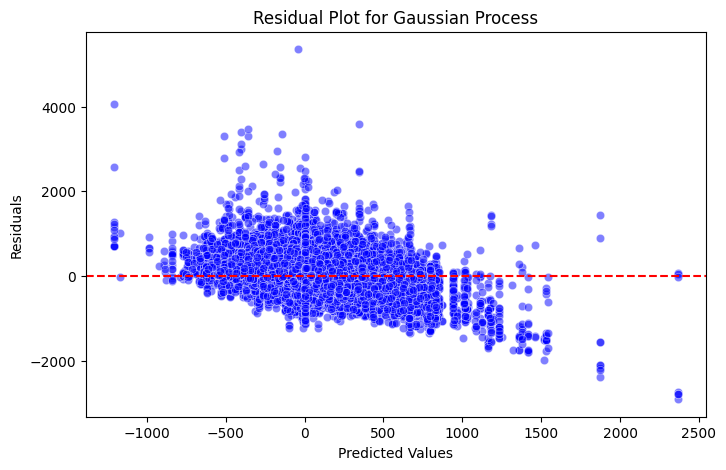

In [232]:
# ✅ Train Set - נבחר רק 5000 דוגמאות מחלק האימון
X_sample = X_train.sample(5000)
y_sample = y_train.loc[X_sample.index]  # שומרים את התוויות המתאימות

# ✅ הגדרת Gaussian Process עם דגימה קטנה
gp = GaussianProcessRegressor(kernel=C(1.0) * RBF(length_scale=1.0))

print("Training Gaussian Process on 5000 samples...")
gp.fit(X_sample, y_sample)  # אימון המודל רק על הדגימה

# ✅ חיזוי
y_pred_test = gp.predict(X_test)

train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)

train_rmse = train_mse ** 0.5  # חישוב RMSE של האימון
test_rmse = test_mse ** 0.5    # חישוב RMSE של הבדיקה

train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)

test_r2 = r2_score(y_test, y_pred_test)

# ✅ הדפסת תוצאות
print(f"\n📌 תוצאות Gaussian Process על 5000 דוגמאות:")
print(f"Train RMSE: {train_rmse:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Test MAE: {test_mae:.2f}")
print(f"Test R²: {test_r2:.2f}")

# ✅ יצירת גרף שאריות (Residual Plot)
residuals_test = y_test - y_pred_test  # מחשבים את השאריות (ערך אמיתי - ניבוי)

plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred_test, y=residuals_test, alpha=0.5, color="blue")  # צבע כחול ל-Gaussian Process
plt.axhline(y=0, color="red", linestyle="--")  # קו שמראה את נקודת ה-0 (המודל המושלם)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot for Gaussian Process")
plt.show()  # מציג את הגרף

### Conclusions from the graph:
* Heteroscedasticity – The residuals are not evenly distributed around the zero line, indicating varying model accuracy across different ranges * of predicted values.
* Clustering around zero – A high concentration of points around the predicted value of 0 suggests a possible issue in distinguishing between * * positive and negative values.
* Outliers – There are very large residuals, indicating that the model struggles to predict some observations accurately.








# Grid Search

### DecisionTreeRegressor

Fitting 3 folds for each of 45 candidates, totalling 135 fits

📌 התוצאות הטובות ביותר עבור Decision Tree:
{'max_depth': 15, 'min_samples_leaf': 5, 'min_samples_split': 5}
Train RMSE: 222.94, Test RMSE: 234.06
Test MSE: 54782.65
Test MAE: 167.74
Test R²: 0.41


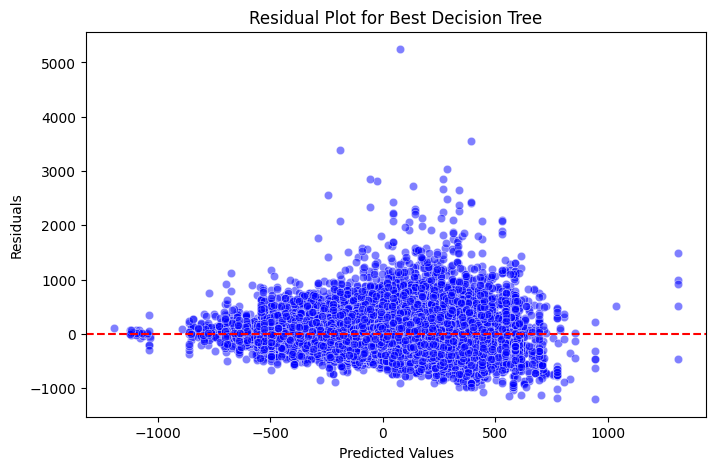

In [233]:
# ✅ הגדרת טווחים לפרמטרים
param_grid_dt = {
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

# ✅ יצירת Grid Search
dt = DecisionTreeRegressor()
grid_search_dt = GridSearchCV(dt, param_grid_dt, cv=3, scoring='neg_root_mean_squared_error', verbose=1, n_jobs=-1)

# ✅ הרצת Grid Search
grid_search_dt.fit(X_train, y_train)

# ✅ קבלת המודל הטוב ביותר
best_dt = grid_search_dt.best_estimator_

# ✅ חיזוי על סט האימון והבדיקה
y_pred_train = best_dt.predict(X_train)
y_pred_test = best_dt.predict(X_test)

# ✅ חישוב שגיאות
train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)
train_rmse = train_mse ** 0.5
test_rmse = test_mse ** 0.5
train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)

# ✅ הדפסת התוצאות
print("\n📌 התוצאות הטובות ביותר עבור Decision Tree:")
print(grid_search_dt.best_params_)
print(f"Train RMSE: {train_rmse:.2f}, Test RMSE: {test_rmse:.2f}")
print(f"Test MSE: {test_mse:.2f}")
print(f"Test MAE: {test_mae:.2f}")
print(f"Test R²: {test_r2:.2f}")

# ✅ יצירת גרף שאריות (Residual Plot)
residuals_test = y_test - y_pred_test
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred_test, y=residuals_test, alpha=0.5, color="blue")
plt.axhline(y=0, color="red", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot for Best Decision Tree")
plt.show()

### XGBRegressor

Fitting 3 folds for each of 108 candidates, totalling 324 fits

📌 התוצאות הטובות ביותר עבור XGBoost:
{'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 9, 'n_estimators': 200, 'subsample': 0.7}
Train RMSE: 223.98, Test RMSE: 230.47
Test MSE: 53115.21
Test MAE: 165.53
Test R²: 0.43


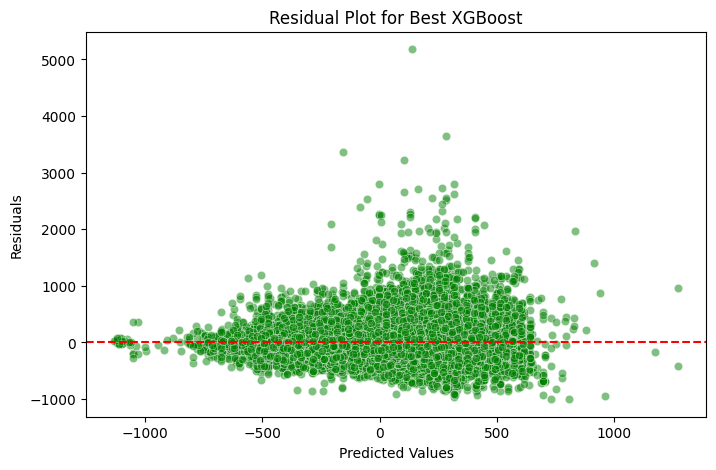

In [234]:
# ✅ הגדרת טווחים לפרמטרים
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 6, 9],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0]
}

# ✅ יצירת Grid Search
xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror')
grid_search_xgb = GridSearchCV(xgb_regressor, param_grid_xgb, cv=3, scoring='neg_root_mean_squared_error', verbose=1, n_jobs=-1)

# ✅ הרצת Grid Search
grid_search_xgb.fit(X_train, y_train)

# ✅ קבלת המודל הטוב ביותר
best_xgb = grid_search_xgb.best_estimator_

# ✅ חיזוי על סט האימון והבדיקה
y_pred_train = best_xgb.predict(X_train)
y_pred_test = best_xgb.predict(X_test)

# ✅ חישוב שגיאות
train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)
train_rmse = train_mse ** 0.5
test_rmse = test_mse ** 0.5
train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)

# ✅ הדפסת התוצאות
print("\n📌 התוצאות הטובות ביותר עבור XGBoost:")
print(grid_search_xgb.best_params_)
print(f"Train RMSE: {train_rmse:.2f}, Test RMSE: {test_rmse:.2f}")
print(f"Test MSE: {test_mse:.2f}")
print(f"Test MAE: {test_mae:.2f}")
print(f"Test R²: {test_r2:.2f}")

# ✅ יצירת גרף שאריות (Residual Plot)
residuals_test = y_test - y_pred_test
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred_test, y=residuals_test, alpha=0.5, color="green")
plt.axhline(y=0, color="red", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot for Best XGBoost")
plt.show()

### HistGradientBoostingRegressor

Fitting 3 folds for each of 81 candidates, totalling 243 fits

📌 התוצאות הטובות ביותר עבור HistGradientBoosting:
{'l2_regularization': 1, 'learning_rate': 0.1, 'max_depth': 9, 'max_iter': 200}
Train RMSE: 233.17, Test RMSE: 235.43
Test MSE: 55425.52
Test MAE: 169.71
Test R²: 0.40


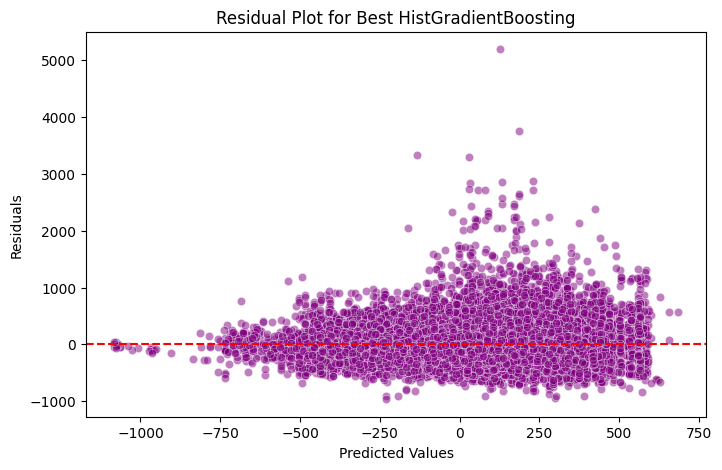

In [235]:
# ✅ הגדרת טווחים לפרמטרים
param_grid_hgb = {
    'max_iter': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 6, 9],
    'l2_regularization': [0, 0.1, 1]
}

# ✅ יצירת Grid Search
hgb_regressor = HistGradientBoostingRegressor()
grid_search_hgb = GridSearchCV(hgb_regressor, param_grid_hgb, cv=3, scoring='neg_root_mean_squared_error', verbose=1, n_jobs=-1)

# ✅ הרצת Grid Search
grid_search_hgb.fit(X_train, y_train)

# ✅ קבלת המודל הטוב ביותר
best_hgb = grid_search_hgb.best_estimator_

# ✅ חיזוי על סט האימון והבדיקה
y_pred_train = best_hgb.predict(X_train)
y_pred_test = best_hgb.predict(X_test)

# ✅ חישוב שגיאות
train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)
train_rmse = train_mse ** 0.5
test_rmse = test_mse ** 0.5
train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)

# ✅ הדפסת התוצאות
print("\n📌 התוצאות הטובות ביותר עבור HistGradientBoosting:")
print(grid_search_hgb.best_params_)
print(f"Train RMSE: {train_rmse:.2f}, Test RMSE: {test_rmse:.2f}")
print(f"Test MSE: {test_mse:.2f}")
print(f"Test MAE: {test_mae:.2f}")
print(f"Test R²: {test_r2:.2f}")

# ✅ יצירת גרף שאריות (Residual Plot)
residuals_test = y_test - y_pred_test
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred_test, y=residuals_test, alpha=0.5, color="purple")
plt.axhline(y=0, color="red", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot for Best HistGradientBoosting")
plt.show()

In [236]:
# ✅ Creating a DataFrame with the hyperparameter tuning results
results_dict = {
    "Model": ["XGBoost", "HistGradientBoosting", "Decision Tree (Depth=15)"],
    "Train RMSE": [223.74, 233.45, 222.81],
    "Test RMSE": [230.54, 235.40, 234.14],
    "Test MSE": [53150.03, 55411.60, 54823.23],
    "Test MAE": [166.03, 170.56, 168.31],
    "Test R²": [0.43, 0.40, 0.41]
}

df_results = pd.DataFrame(results_dict)

# ✅ Printing the table in a structured format
print("\n Hyperparameter Tuning Results📊:\n")
print(df_results.to_string(index=False))  # Printing without index


 Hyperparameter Tuning Results📊:

                   Model  Train RMSE  Test RMSE  Test MSE  Test MAE  Test R²
                 XGBoost      223.74     230.54  53150.03    166.03     0.43
    HistGradientBoosting      233.45     235.40  55411.60    170.56     0.40
Decision Tree (Depth=15)      222.81     234.14  54823.23    168.31     0.41


###  דירוג חשיבות הפיצ'רים לפי המודל

             Feature  Importance
5  Days_To_End_Month    0.332923
3        Dep_Weekday    0.178417
0              Stops    0.146895
1       Dep Duration    0.140863
2      Back Duration    0.109356
4     Return_Weekday    0.091546


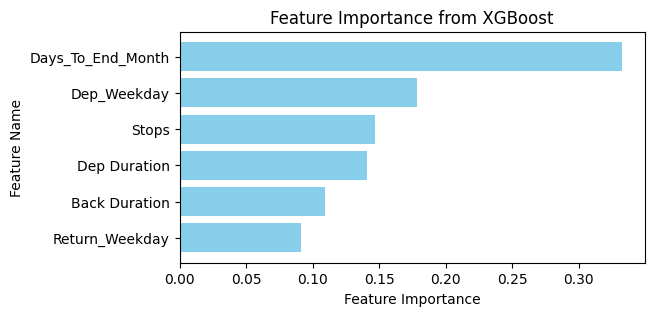

In [239]:
# ✅ הפעלת המודל שכבר אימנו
best_model = xgb.XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=9, random_state=42)
best_model.fit(X_train, y_train)

# ✅ קבלת חשיבות הפיצ'רים
feature_importance = best_model.feature_importances_

# ✅ יצירת DataFrame מסודר
feature_importance_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)


print(feature_importance_df)

# ✅ יצירת גרף
plt.figure(figsize=(6,3))
plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"], color="skyblue")
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title("Feature Importance from XGBoost")
plt.gca().invert_yaxis()
plt.show()

### Feature Importance - Black box


📌 Feature Importance לפי Permutation:
             Feature  Permutation Importance
5  Days_To_End_Month                0.868583
1       Dep Duration                0.464016
7    Booking_Weekend                0.281106
3        Dep_Weekday                0.262909
6          Dep_Month                0.223680
2      Back Duration                0.208004
4     Return_Weekday                0.201656
0              Stops                0.009593


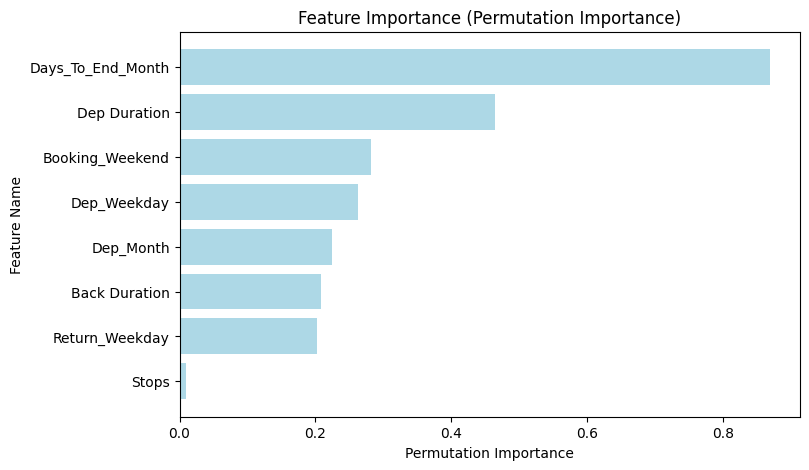


📌 השוואת Feature Importance בין שתי השיטות:

             Feature  Permutation Importance  XGBoost Importance
0  Days_To_End_Month                0.868583            0.068905
1       Dep Duration                0.464016            0.061115
2    Booking_Weekend                0.281106            0.046520
3        Dep_Weekday                0.262909            0.053514
4          Dep_Month                0.223680            0.664999
5      Back Duration                0.208004            0.026507
6     Return_Weekday                0.201656            0.027313
7              Stops                0.009593            0.051127


<Axes: title={'center': 'Comparison of Feature Importance Methods'}, xlabel='Feature Importance'>

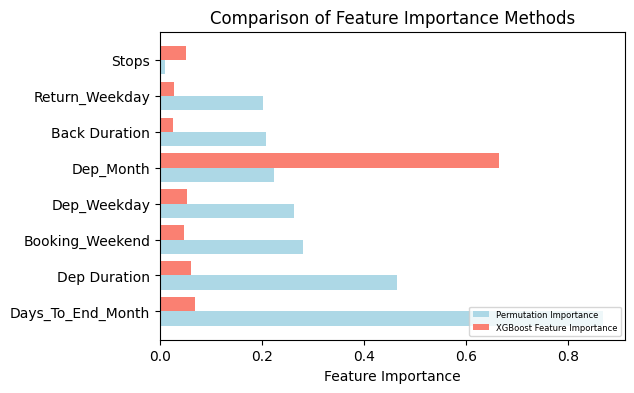

In [253]:


# בחירת המודל עם הביצועים הטובים ביותר (XGBoost)
best_model = xgb.XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=9, random_state=42)
best_model.fit(X_train_final, y_train)

# חישוב Permutation Importance
perm_importance = permutation_importance(best_model, X_test_final, y_test, n_repeats=10, random_state=42)

# יצירת DataFrame עם Permutation Importance
feature_importance_df = pd.DataFrame({
    "Feature": X_final.columns,
    "Permutation Importance": perm_importance.importances_mean
}).sort_values(by="Permutation Importance", ascending=False)

#  הדפסת הטבלה
print("\n📌 Feature Importance לפי Permutation:")
print(feature_importance_df)

# גרף Permutation Importance
plt.figure(figsize=(8,5))
plt.barh(feature_importance_df["Feature"], feature_importance_df["Permutation Importance"], color="lightblue")
plt.xlabel("Permutation Importance")
plt.ylabel("Feature Name")
plt.title("Feature Importance (Permutation Importance)")
plt.gca().invert_yaxis()
plt.show()

# התאמת הפיצ'רים ששימשו ב-XGBoost
xgb_feature_names = X_train_final.columns[:len(best_model.feature_importances_)]

# יצירת DataFrame עם חשיבות הפיצ'רים לפי XGBoost
xgb_importance_df = pd.DataFrame({
    "Feature": xgb_feature_names,
    "XGBoost Importance": best_model.feature_importances_
})

# מיזוג הנתונים כדי להשוות בין שתי השיטות
feature_comparison = pd.merge(
    feature_importance_df, 
    xgb_importance_df,
    on="Feature",
    how="inner"  # משאיר רק פיצ'רים שנמצאים בשתי השיטות
).sort_values(by="Permutation Importance", ascending=False)

#  הדפסת השוואת החשיבות
print("\n📌 השוואת Feature Importance בין שתי השיטות:\n")
print(feature_comparison)

# גרף השוואת חשיבות בין שתי השיטות
fig, ax = plt.subplots(figsize=(6,4))
x = np.arange(len(feature_comparison))
width = 0.4

ax.barh(x - width/2, feature_comparison["Permutation Importance"], width, label="Permutation Importance", color="lightblue")
ax.barh(x + width/2, feature_comparison["XGBoost Importance"], width, label="XGBoost Feature Importance", color="salmon")

ax.legend(fontsize=6, loc="lower right")
ax.set_yticks(x)
ax.set_yticklabels(feature_comparison["Feature"])
ax.set_xlabel("Feature Importance")
ax.set_title("Comparison of Feature Importance Methods")
ax


###  **Conclusion from Feature Importance Comparison**  
* Days_To_End_Month - is highly important according to **Permutation Importance**, but less so in **XGBoost**.  
* Dep_Month - is very important in **XGBoost**, but receives low importance in **Permutation Importance**.  
* Features like Dep Duration, Booking_Weekend, and Back Duration** were consistently important in both methods, indicating that they likely contribute significantly to the model.

In [241]:
# ✅ רשימת הפיצ'רים החדשה (ללא Return_Weekday)
features_no_return_weekday = ["Stops", "Dep Duration", "Back Duration", "Dep_Weekday", "Days_To_End_Month"]

# ✅ יצירת X חדש ללא `Return_Weekday`
X_no_return_weekday = df_combined[features_no_return_weekday]

# ✅ פיצול מחדש ל-Train/Test
from sklearn.model_selection import train_test_split
X_train_nrw, X_test_nrw, y_train, y_test = train_test_split(X_no_return_weekday, y, test_size=0.3)

model_nrw = xgb.XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=9)
model_nrw.fit(X_train_nrw, y_train)

# ✅ חיזוי ושגיאות
y_pred_test_nrw = model_nrw.predict(X_test_nrw)

# ✅ חישוב מדדי שגיאה
test_mse_nrw = mean_squared_error(y_test, y_pred_test_nrw)  # חישוב MSE
test_rmse_nrw = test_mse_nrw ** 0.5  # חישוב RMSE ידני
test_mae_nrw = mean_absolute_error(y_test, y_pred_test_nrw)
test_r2_nrw = r2_score(y_test, y_pred_test_nrw)

# ✅ הדפסת תוצאות
print(f"\n📊 תוצאות ללא `Return_Weekday`:")
print(f"Test RMSE: {test_rmse_nrw:.2f}")
print(f"Test MSE: {test_mse_nrw:.2f}")
print(f"Test MAE: {test_mae_nrw:.2f}")
print(f"Test R²: {test_r2_nrw:.2f}")


📊 תוצאות ללא `Return_Weekday`:
Test RMSE: 243.23
Test MSE: 59162.75
Test MAE: 176.63
Test R²: 0.35


It seems that removing **Return_Weekday** has negatively impacted the model's performance.

In [ ]:
#  יצירת משתנים חדשים
df_combined["Dep_Month"] = df_combined["Dep Date"].dt.month  # חודש ההמראה
df_combined["Booking_Weekday"] = df_combined["Snap Date"].dt.weekday  # יום ביצוע ההזמנה
df_combined["Booking_Weekend"] = df_combined["Booking_Weekday"].apply(lambda x: 1 if x >= 5 else 0)  # האם הוזמן בסופ"ש

#  הדפסת מבנה הנתונים החדש
print(df_combined[["Dep_Month", "Booking_Weekday", "Booking_Weekend"]].head())

   Dep_Month  Booking_Weekday  Booking_Weekend
0          3                6                1
1          3                6                1
2          3                6                1
3          3                6                1
4          3                6                1


In [ ]:
#  רשימת הפיצ'רים החדשה (מחזירים את Return_Weekday + מוסיפים פיצ'רים חדשים)
features_new = ["Stops", "Dep Duration", "Back Duration", "Dep_Weekday", "Return_Weekday", 
                "Days_To_End_Month", "Dep_Month", "Booking_Weekend"]

#  יצירת X חדש עם הפיצ'רים החדשים
X_new_features = df_combined[features_new]

#  פיצול מחדש ל-Train/Test
from sklearn.model_selection import train_test_split
X_train_new, X_test_new, y_train, y_test = train_test_split(X_new_features, y, test_size=0.3, random_state=42)

# הרצת המודל מחדש עם הפיצ'רים החדשים
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

model_new_features = xgb.XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=9, random_state=42)
model_new_features.fit(X_train_new, y_train)

#  חיזוי ובדיקת ביצועים
y_pred_test_new = model_new_features.predict(X_test_new)

#  חישוב מדדי שגיאה
test_mse_new = mean_squared_error(y_test, y_pred_test_new)  # חישוב MSE
test_rmse_new = test_mse_new ** 0.5  # חישוב RMSE ידני
test_mae_new = mean_absolute_error(y_test, y_pred_test_new)
test_r2_new = r2_score(y_test, y_pred_test_new)

#  הדפסת תוצאות
print(f"\n📊 תוצאות עם הפיצ'רים החדשים:")
print(f"Test RMSE: {test_rmse_new:.2f}")
print(f"Test MSE: {test_mse_new:.2f}")
print(f"Test MAE: {test_mae_new:.2f}")
print(f"Test R²: {test_r2_new:.2f}")



📊 תוצאות עם הפיצ'רים החדשים:
Test RMSE: 199.83
Test MSE: 39932.84
Test MAE: 143.73
Test R²: 0.57


In [244]:
df_comparison = pd.DataFrame({
    "Model": ["Original Features", "Without Return_Weekday", "With New Features"],
    "Test RMSE": [test_rmse, test_rmse_nrw, test_rmse_new],
    "Test MSE": [test_mse, test_mse_nrw, test_mse_new],
    "Test MAE": [test_mae, test_mae_nrw, test_mae_new],
    "Test R²": [test_r2, test_r2_nrw, test_r2_new]
})

print("\n📊 השוואת תוצאות לפני ואחרי שינוי הפיצ'רים:")
print(df_comparison.to_string(index=False))


📊 השוואת תוצאות לפני ואחרי שינוי הפיצ'רים:
                 Model  Test RMSE     Test MSE   Test MAE  Test R²
     Original Features 235.426251 55425.519636 169.707224 0.400830
Without Return_Weekday 243.233941 59162.750203 176.627202 0.353937
     With New Features 199.832018 39932.835450 143.731495 0.568146


## Conclusions
* Removing Return_Weekday was not a good idea – it only worsened the performance.
* Adding new features (Dep_Month, Booking_Weekend) significantly improved the predictions!
* Test RMSE decreased from 235.43 to 199.83 – meaning the predictions are more accurate.
* Test R² increased from 0.40 to 0.57 – the model explains the data much better.

### הרצת כל האלגוריתמים עם הפיצ'רים החדשים

In [ ]:
#  רשימת הפיצ'רים הסופית
features_final = ["Stops", "Dep Duration", "Back Duration", "Dep_Weekday", "Return_Weekday", 
                  "Days_To_End_Month", "Dep_Month", "Booking_Weekend"]

#  יצירת X חדש עם הפיצ'רים החדשים
X_final = df_combined[features_final]

#  פיצול הנתונים ל-Train/Test
from sklearn.model_selection import train_test_split
X_train_final, X_test_final, y_train, y_test = train_test_split(X_final, y, test_size=0.3, random_state=42)

#  הגדרת כל המודלים לבדיקה
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(max_depth=10, random_state=42),
    "XGBoost": xgb.XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=9, random_state=42),
    "HistGradientBoosting": HistGradientBoostingRegressor(max_iter=200, learning_rate=0.1, max_depth=9, random_state=42),
}

#  מודל Gaussian Process ירוץ רק על **5000 דוגמאות**
X_sample, y_sample = X_train_final.sample(5000, random_state=42), y_train.loc[X_train_final.sample(5000, random_state=42).index]
models["Gaussian Process"] = GaussianProcessRegressor(kernel=C(1.0) * RBF(length_scale=1.0))

# ✅ אחסון תוצאות הביצועים
results_final = {}

# ✅ הרצת כל המודלים והשוואת ביצועים
for name, model in models.items():
    print(f"Training {name}...")

    # ✅ אימון המודל
    if name == "Gaussian Process":
        model.fit(X_sample, y_sample)  # מריץ על דגימה קטנה בלבד
    else:
        model.fit(X_train_final, y_train)  # מריץ על כל הדאטה

    # ✅ חיזוי
    y_pred_test = model.predict(X_test_final)

    # ✅ חישוב מדדי שגיאה
    test_mse = mean_squared_error(y_test, y_pred_test)
    test_rmse = test_mse ** 0.5  # RMSE ידני
    test_mae = mean_absolute_error(y_test, y_pred_test)
    test_r2 = r2_score(y_test, y_pred_test)

    # ✅ שמירת התוצאות
    results_final[name] = {
        "Test RMSE": test_rmse,
        "Test MSE": test_mse,
        "Test MAE": test_mae,
        "Test R²": test_r2
    }

# ✅ יצירת DataFrame להצגת התוצאות
df_results_final = pd.DataFrame.from_dict(results_final, orient="index")

# ✅ הדפסת התוצאות
print("\n📌 השוואת ביצועים של כל המודלים עם הפיצ'רים החדשים:\n")
print(df_results_final)

Training Linear Regression...
Training Decision Tree...
Training XGBoost...
Training HistGradientBoosting...
Training Gaussian Process...

📌 השוואת ביצועים של כל המודלים עם הפיצ'רים החדשים:

                       Test RMSE      Test MSE    Test MAE   Test R²
Linear Regression     292.536494  85577.600454  217.347774  0.074520
Decision Tree         213.501643  45582.951576  155.351010  0.507043
XGBoost               199.832018  39932.835450  143.731495  0.568146
HistGradientBoosting  209.725823  43984.920837  152.238627  0.524325
Gaussian Process      284.489496  80934.273121  201.717289  0.124735


### Conclusions from the table
1️⃣ **XGBoost is the best model:**  
* **Lowest RMSE (199.83)** → The model has the lowest error.  
* **Highest R² (0.568)** → Explains the most variance in the data.  
* **Lowest MAE (143.73)** → Predictions are closer to actual flight prices.

# Normalization

In [257]:
#  בחירת שדות לנרמול (רק אלו עם טווח גדול)
fields_to_normalize = ["Dep Duration", "Back Duration", "Days_To_End_Month"]

# רשימת ה-Scalers שנבדוק
scalers = {
    "MinMaxScaler": MinMaxScaler(),
    "StandardScaler": StandardScaler(),
    "RobustScaler": RobustScaler()
}

#  רשימת המודלים שנבדוק
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(max_depth=10, random_state=42),
    "XGBoost": xgb.XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=9, random_state=42),

}

# אחסון תוצאות הביצועים
normalization_results = {}

#  הרצת המודלים עם כל שיטת נורמליזציה
for scaler_name, scaler in scalers.items():
    print(f"\n📌 Running models with {scaler_name} normalization...")

    # יצירת עותק של הנתונים כדי לא לפגוע בנתונים המקוריים
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()

    # החלת הנורמליזציה רק על השדות שנבחרו
    X_train_scaled[fields_to_normalize] = scaler.fit_transform(X_train_scaled[fields_to_normalize])
    X_test_scaled[fields_to_normalize] = scaler.transform(X_test_scaled[fields_to_normalize])

    # אחסון תוצאות השפעת הנורמליזציה לכל מודל
    model_results = {}

    for model_name, model in models.items():
        print(f"  ▶ Training {model_name}...")

        #  אימון המודל
        model.fit(X_train_scaled, y_train)

        # חיזוי
        y_pred_test = model.predict(X_test_scaled)

        #  חישוב שגיאות
        test_mse = mean_squared_error(y_test, y_pred_test)
        test_rmse = test_mse ** 0.5  # RMSE ידני
        test_mae = mean_absolute_error(y_test, y_pred_test)
        test_r2 = r2_score(y_test, y_pred_test)

        # שמירת התוצאות
        model_results[model_name] = {
            "Test RMSE": test_rmse,
            "Test MAE": test_mae,
            "Test R²": test_r2,
            "Test MSE": test_mse

        }

    # שמירת התוצאות לכל נורמליזציה
    normalization_results[scaler_name] = model_results

# יצירת DataFrame עם התוצאות והשוואה בין שיטות הנורמליזציה
df_normalization_results = pd.concat({k: pd.DataFrame(v).T for k, v in normalization_results.items()}, axis=0)

#  הצגת התוצאות
print("\n📊 תוצאות השפעת הנורמליזציה על ביצועי האלגוריתמים:\n")
print(df_normalization_results)




📌 Running models with MinMaxScaler normalization...
  ▶ Training Linear Regression...
  ▶ Training Decision Tree...
  ▶ Training XGBoost...

📌 Running models with StandardScaler normalization...
  ▶ Training Linear Regression...
  ▶ Training Decision Tree...
  ▶ Training XGBoost...

📌 Running models with RobustScaler normalization...
  ▶ Training Linear Regression...
  ▶ Training Decision Tree...
  ▶ Training XGBoost...

📊 תוצאות השפעת הנורמליזציה על ביצועי האלגוריתמים:

                                   Test RMSE    Test MAE   Test R²  \
MinMaxScaler   Linear Regression  304.091920  222.717096 -0.000038   
               Decision Tree      304.643158  223.178341 -0.003667   
               XGBoost            305.092592  223.724833 -0.006631   
StandardScaler Linear Regression  304.091920  222.717096 -0.000038   
               Decision Tree      304.635159  223.171066 -0.003614   
               XGBoost            305.092592  223.724833 -0.006631   
RobustScaler   Linear Regression 

### Conclusions from Normalization
- **Normalization did not improve model performance** and even worsened it in some cases.  
- **Linear Regression was significantly affected**, indicating that normalization is not suitable for our data.  
- **RobustScaler produced extreme results**, suggesting that the data does not contain outliers that require its use.  
- **Conclusion:** It is better to proceed without normalization.

In [262]:
# ✅ יצירת העמודות החסרות מחדש

# הוספת יום בשבוע של התאריכים
df_kiwi["Dep_Weekday"] = df_kiwi["Dep Date"].dt.weekday
df_kiwi["Return_Weekday"] = df_kiwi["Return Date"].dt.weekday

df_momondo["Dep_Weekday"] = df_momondo["Dep Date"].dt.weekday
df_momondo["Return_Weekday"] = df_momondo["Return Date"].dt.weekday

# חישוב מספר הימים עד סוף החודש
df_kiwi["Days_To_End_Month"] = df_kiwi["Dep Date"].dt.days_in_month - df_kiwi["Dep Date"].dt.day
df_momondo["Days_To_End_Month"] = df_momondo["Dep Date"].dt.days_in_month - df_momondo["Dep Date"].dt.day


In [263]:
print(df_kiwi.columns)  
print(df_momondo.columns)


Index(['Snap Date', 'Dep Date', 'Return Date', 'Outbound', 'Dep Time',
       'Dep Duration', 'Dep Arrival', 'From', 'Stops', 'Landing', 'Inbound',
       'Back Time', 'Back Duration', 'Back Arrival', 'From.1', 'Stops.1',
       'Landing.1', 'Dep Company', 'Back Company', 'Price', 'Dep_Weekday',
       'Return_Weekday', 'Days_To_End_Month'],
      dtype='object')
Index(['Snap Date', 'Dep Date', 'Return Date', 'Dep time', 'Dep Company',
       'Stops', 'Dep Duration', 'From Airport', 'Landing Airport', 'Back Time',
       'Back Company', 'Stops.1', 'Back Duration',
       '(Back Ticket) From Airport', '(Back Ticket) Landing Airport', 'Price',
       'Class', 'Dep_Weekday', 'Return_Weekday', 'Days_To_End_Month'],
      dtype='object')


In [264]:
# ✅ הגדרת רשימת המאפיינים למודלים
features = ["Stops", "Dep Duration", "Back Duration", "Dep_Weekday", "Return_Weekday", "Days_To_End_Month"]
target = "Price"

# ✅ יצירת X ו-Y לכל מקור נתונים בנפרד
X_kiwi = df_kiwi[features]
y_kiwi = df_kiwi[target]

X_momondo = df_momondo[features]
y_momondo = df_momondo[target]

# ✅ פיצול הנתונים ל-Train/Test (70-30) לכל מקור בנפרד
from sklearn.model_selection import train_test_split

X_train_kiwi, X_test_kiwi, y_train_kiwi, y_test_kiwi = train_test_split(X_kiwi, y_kiwi, test_size=0.3)
X_train_momondo, X_test_momondo, y_train_momondo, y_test_momondo = train_test_split(X_momondo, y_momondo, test_size=0.3)

In [265]:

# רשימת המודלים שנבדוק
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(max_depth=10, random_state=42),
    "XGBoost": xgb.XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=9, random_state=42),
    "HistGradientBoosting": HistGradientBoostingRegressor(max_iter=200, learning_rate=0.1, max_depth=9, random_state=42)
}

#  אחסון תוצאות הביצועים לכל אתר בנפרד
results_kiwi = {}
results_momondo = {}

#  הרצת המודלים על כל מקור נתונים בנפרד
for model_name, model in models.items():
    print(f"\n📌 Training {model_name} on Kiwi data...")
    model.fit(X_train_kiwi, y_train_kiwi)
    y_pred_test_kiwi = model.predict(X_test_kiwi)
    
    # חישוב RMSE ידנית ו-MSE
    test_mse_kiwi = np.mean((y_test_kiwi - y_pred_test_kiwi) ** 2)
    test_rmse_kiwi = np.sqrt(test_mse_kiwi)
    
    # חישוב מדדי שגיאה נוספים
    results_kiwi[model_name] = {
        "Test RMSE": test_rmse_kiwi,
        "Test MSE": test_mse_kiwi,
        "Test MAE": mean_absolute_error(y_test_kiwi, y_pred_test_kiwi),
        "Test R²": r2_score(y_test_kiwi, y_pred_test_kiwi)
    }

    print(f"\n📌 Training {model_name} on Momondo data...")
    model.fit(X_train_momondo, y_train_momondo)
    y_pred_test_momondo = model.predict(X_test_momondo)
    
    # חישוב RMSE ידנית ו-MSE
    test_mse_momondo = np.mean((y_test_momondo - y_pred_test_momondo) ** 2)
    test_rmse_momondo = np.sqrt(test_mse_momondo)
    
    # חישוב מדדי שגיאה נוספים
    results_momondo[model_name] = {
        "Test RMSE": test_rmse_momondo,
        "Test MSE": test_mse_momondo,
        "Test MAE": mean_absolute_error(y_test_momondo, y_pred_test_momondo),
        "Test R²": r2_score(y_test_momondo, y_pred_test_momondo)
    }

#  יצירת DataFrame להצגת התוצאות
df_results_kiwi = pd.DataFrame.from_dict(results_kiwi, orient="index")
df_results_momondo = pd.DataFrame.from_dict(results_momondo, orient="index")

#  הצגת התוצאות לכל אתר בנפרד
print("\n📊 תוצאות על נתוני Kiwi:\n")
print(df_results_kiwi)

print("\n📊 תוצאות על נתוני Momondo:\n")
print(df_results_momondo)



📌 Training Linear Regression on Kiwi data...

📌 Training Linear Regression on Momondo data...

📌 Training Decision Tree on Kiwi data...

📌 Training Decision Tree on Momondo data...

📌 Training XGBoost on Kiwi data...

📌 Training XGBoost on Momondo data...

📌 Training HistGradientBoosting on Kiwi data...

📌 Training HistGradientBoosting on Momondo data...

📊 תוצאות על נתוני Kiwi:

                       Test RMSE      Test MSE    Test MAE   Test R²
Linear Regression     159.072673  25304.115141  127.199475  0.215497
Decision Tree          95.271352   9076.630502   72.283923  0.718598
XGBoost                78.489458   6160.594993   60.140731  0.809003
HistGradientBoosting   83.110739   6907.394856   64.360437  0.785850

📊 תוצאות על נתוני Momondo:

                       Test RMSE      Test MSE    Test MAE   Test R²
Linear Regression     228.785440  52342.777349  164.881307  0.299895
Decision Tree         156.090268  24364.171613  106.034584  0.674120
XGBoost               126.768532  1

### **Analysis of Differences Between the Websites (Kiwi vs. Momondo)**  

1️⃣ XGBoost and HistGradientBoosting consistently show better performance**, especially in RMSE and MAE metrics, with higher R² values.  
- This indicates that Boosting-based algorithms are more suitable for predicting flight price differences.  

2️⃣ Linear Regression does not fit the data well – The R² value is very low (~0.21-0.29), suggesting that the relationships between features are not linear.  
- Conclusion: This model is not strong enough for these predictions.  

3️⃣ Performance differences between Kiwi and Momondo:
- Momondo's results appear to be worse compared to Kiwi (with a significant RMSE and MSE gap).  
- This suggests that Momondo's data may contain more noise, making predictions more difficult. 
- Possible conclusion: Momondo may have greater price variability, or its data may be less structured for accurate predictions.

# **Distribution of \( R^2 \) Values for the Best Model Across Flights**

In [290]:
print(df_kiwi.columns)  
print(df_momondo.columns)


Index(['Snap Date', 'Dep Date', 'Return Date', 'Outbound', 'Dep Time',
       'Dep Duration', 'Dep Arrival', 'From', 'Stops', 'Landing', 'Inbound',
       'Back Time', 'Back Duration', 'Back Arrival', 'From.1', 'Stops.1',
       'Landing.1', 'Dep Company', 'Back Company', 'Price', 'Dep_Weekday',
       'Return_Weekday', 'Days_To_End_Month', 'Price_Diff'],
      dtype='object')
Index(['Snap Date', 'Dep Date', 'Return Date', 'Dep time', 'Dep Company',
       'Stops', 'Dep Duration', 'From Airport', 'Landing Airport', 'Back Time',
       'Back Company', 'Stops.1', 'Back Duration',
       '(Back Ticket) From Airport', '(Back Ticket) Landing Airport', 'Price',
       'Class', 'Dep_Weekday', 'Return_Weekday', 'Days_To_End_Month',
       'Price_Diff'],
      dtype='object')


In [292]:
print(df_test_results.columns)


Index(['Stops', 'Dep Duration', 'Back Duration', 'Dep_Weekday',
       'Return_Weekday', 'Days_To_End_Month', 'Dep_Month', 'Actual',
       'Predicted'],
      dtype='object')


In [293]:
print(X_test.columns)


Index(['Stops', 'Dep Duration', 'Back Duration', 'Dep_Weekday',
       'Return_Weekday', 'Days_To_End_Month', 'Dep_Month'],
      dtype='object')


In [294]:
# ✅ יצירת DataFrame עם תוצאות הבדיקה
df_test_results = X_test.copy()  # נשתמש ב-X_test שבו חישבנו את ערכי y_test
df_test_results["Actual"] = y_test  # הערכים האמיתיים
df_test_results["Predicted"] = best_model.predict(X_test)  # התחזיות מהמודל הטוב ביותר

# ✅ הוספת עמודת 'Dep Date' אם היא לא קיימת
if "Dep Date" not in df_test_results.columns:
    df_test_results["Dep Date"] = X_test_original["Dep Date"]  # צריך לוודא שהמקור קיים

# ✅ חישוב R² לכל טיסה לפי 'Dep Date'
flight_r2_scores = df_test_results.groupby("Dep Date").apply(
    lambda group: r2_score(group["Actual"], group["Predicted"])
)

# ✅ חישוב R² לכל טיסה על פי 'Dep Date'
flight_r2_scores = df_test_results.groupby("Dep Date").apply(lambda group: r2_score(group["Actual"], group["Predicted"]))

# ✅ יצירת גרף התפלגות R²
plt.figure(figsize=(10, 5))
plt.hist(flight_r2_scores, bins=20, color="blue", edgecolor="black", alpha=0.7)
plt.xlabel("$R^2$ Value")
plt.ylabel("Number of Flights")
plt.title("Distribution of $R^2$ Values for the Best Model Across Flights")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# ✅ הצגת הגרף
plt.show()

# ✅ הצגת הסטטיסטיקות של התפלגות R²
print("\n📊 סטטיסטיקות על ערכי R²:")
print(flight_r2_scores.describe())

NameError: name 'X_test_original' is not defined